In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.datasets import get_rdataset
import sklearn.model_selection as skm
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS
import statsmodels.api as sm

# New imports
from sklearn.tree import (
    DecisionTreeClassifier as DTC,
    DecisionTreeRegressor as DTR,
    plot_tree,
    export_text,
)
from sklearn.metrics import accuracy_score, log_loss
from sklearn.ensemble import (
    RandomForestRegressor as RF,
    RandomForestClassifier as RFC,
    GradientBoostingRegressor as GBR,
    GradientBoostingClassifier as GBC,
)
from ISLP.bart import BART

# Lab

## Fitting Classification Trees

In [3]:
Carseats = load_data("Carseats")
High = np.where(Carseats.Sales > 8, "Yes", "No")

In [4]:
model = MS(Carseats.columns.drop("Sales"), intercept=False)
D = model.fit_transform(Carseats)
feature_names = list(D.columns)
X = np.asarray(D)

In [5]:
clf = DTC(criterion="entropy", max_depth=3, random_state=0)
clf.fit(X, High)

,criterion,'entropy'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [6]:
accuracy_score(High, clf.predict(X))

0.79

In [7]:
resid_dev = np.sum(log_loss(High, clf.predict_proba(X)))
resid_dev

np.float64(0.4710647062649358)

A small deviance
indicates a tree that provides a good fit to the (training) data.

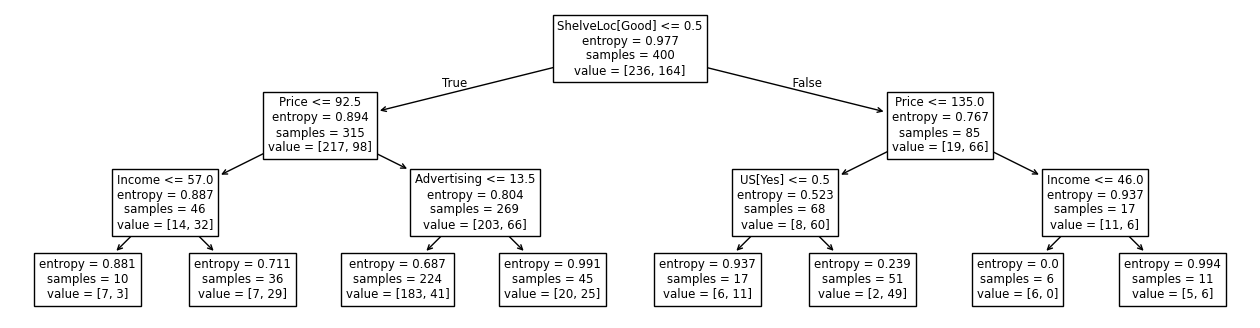

In [8]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot()
tree = plot_tree(clf, feature_names=feature_names, ax=ax)

In [9]:
print(export_text(clf, feature_names=feature_names, show_weights=True))

|--- ShelveLoc[Good] <= 0.50
|   |--- Price <= 92.50
|   |   |--- Income <= 57.00
|   |   |   |--- weights: [7.00, 3.00] class: No
|   |   |--- Income >  57.00
|   |   |   |--- weights: [7.00, 29.00] class: Yes
|   |--- Price >  92.50
|   |   |--- Advertising <= 13.50
|   |   |   |--- weights: [183.00, 41.00] class: No
|   |   |--- Advertising >  13.50
|   |   |   |--- weights: [20.00, 25.00] class: Yes
|--- ShelveLoc[Good] >  0.50
|   |--- Price <= 135.00
|   |   |--- US[Yes] <= 0.50
|   |   |   |--- weights: [6.00, 11.00] class: Yes
|   |   |--- US[Yes] >  0.50
|   |   |   |--- weights: [2.00, 49.00] class: Yes
|   |--- Price >  135.00
|   |   |--- Income <= 46.00
|   |   |   |--- weights: [6.00, 0.00] class: No
|   |   |--- Income >  46.00
|   |   |   |--- weights: [5.00, 6.00] class: Yes



In [10]:
validation = skm.ShuffleSplit(n_splits=1, test_size=200, random_state=0)
results = skm.cross_validate(clf, D, High, cv=validation)
results["test_score"]

array([0.685])

#### Pruning the tree

In [11]:
(X_train, X_test, High_train, High_test) = skm.train_test_split(
    X, High, test_size=0.5, random_state=0
)

In [12]:
clf = DTC(criterion="entropy", random_state=0)
clf.fit(X_train, High_train)
accuracy_score(High_test, clf.predict(X_test))

0.735

In [13]:
ccp_path = clf.cost_complexity_pruning_path(X_train, High_train)
kfold = skm.KFold(10, random_state=1, shuffle=True)

In [14]:
grid = skm.GridSearchCV(
    clf, {"ccp_alpha": ccp_path.ccp_alphas}, refit=True, cv=kfold, scoring="accuracy"
)
grid.fit(X_train, High_train)
grid.best_score_

np.float64(0.685)

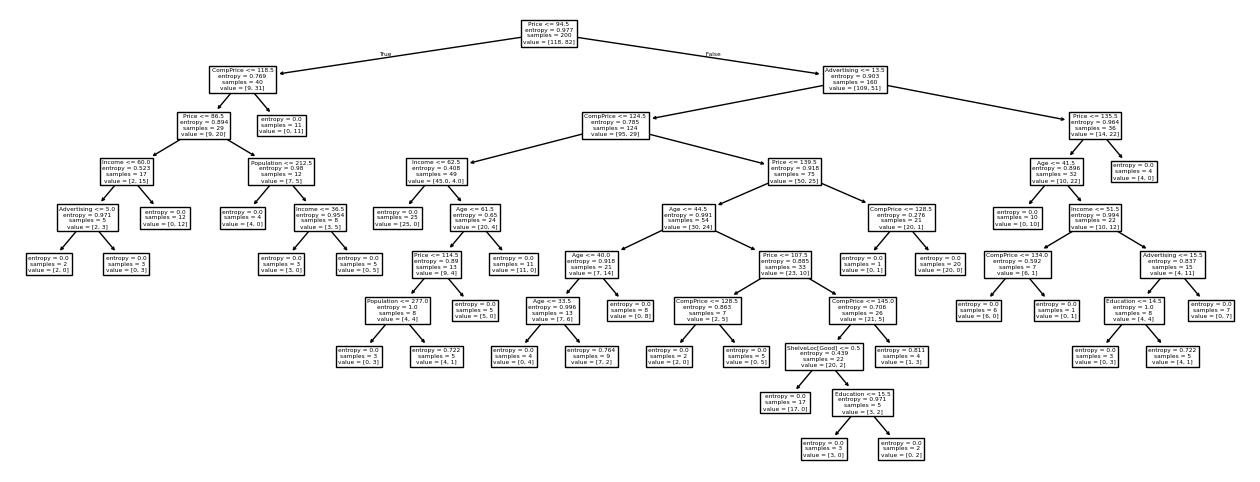

In [15]:
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot()
best_ = grid.best_estimator_
tree = plot_tree(best_, feature_names=feature_names, ax=ax)

In [16]:
best_.tree_.n_leaves

np.int64(30)

In [17]:
print(accuracy_score(High_test, best_.predict(X_test)))
confusion = confusion_table(best_.predict(X_test), High_test)
confusion

0.72


Truth,No,Yes
Predicted,,
No,94,32
Yes,24,50


## Fitting regression trees

In [18]:
Boston = load_data("Boston")
model = MS(Boston.columns.drop("medv"), intercept=False)
D = model.fit_transform(Boston)
feature_names = list(D.columns)
X = np.asarray(D)

In [19]:
(X_train, X_test, y_train, y_test) = skm.train_test_split(
    X, Boston["medv"], test_size=0.3, random_state=0
)

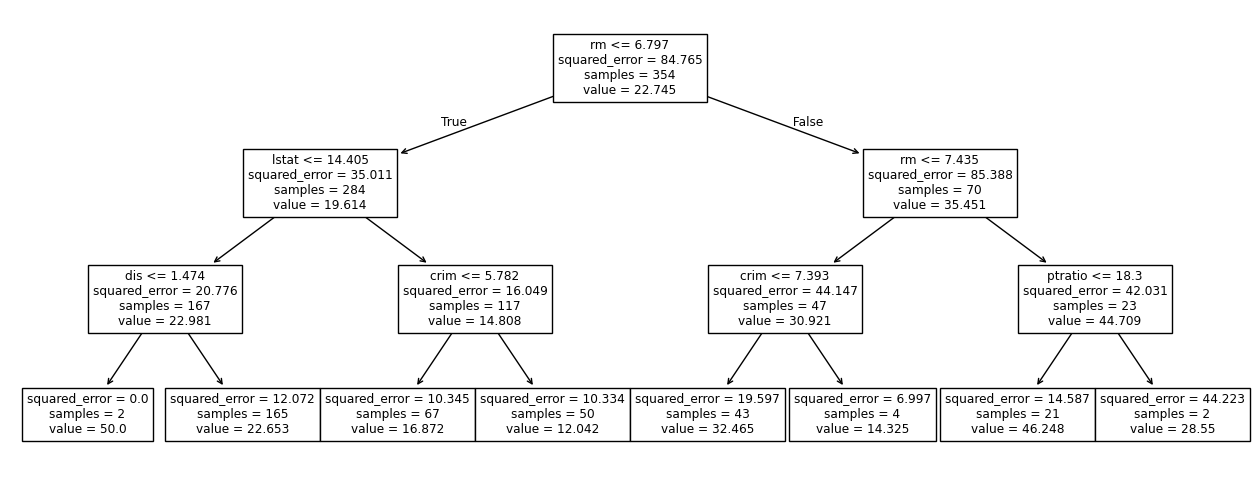

In [20]:
reg = DTR(max_depth=3)
reg.fit(X_train, y_train)
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot()
tree = plot_tree(reg, feature_names=feature_names, ax=ax)

In [21]:
ccp_path = reg.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(5, shuffle=True, random_state=10)
grid = skm.GridSearchCV(
    reg,
    {"ccp_alpha": ccp_path.ccp_alphas},
    refit=True,
    cv=kfold,
    scoring="neg_mean_squared_error",
)
G = grid.fit(X_train, y_train)

In [22]:
best_ = grid.best_estimator_
np.mean((y_test - best_.predict(X_test)) ** 2)

np.float64(28.069857549754044)

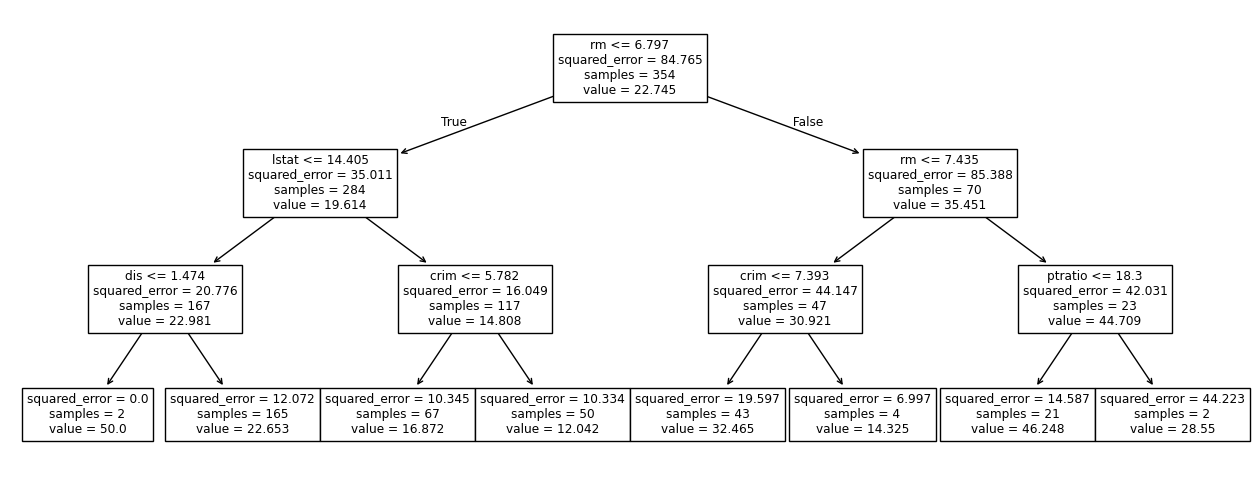

In [23]:
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot()
tree = plot_tree(G.best_estimator_, feature_names=feature_names, ax=ax)

## Bagging and Random Forests

In [24]:
bag_boston = RF(max_features=X_train.shape[1], random_state=0)
bag_boston.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,12
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


np.float64(14.634700151315787)

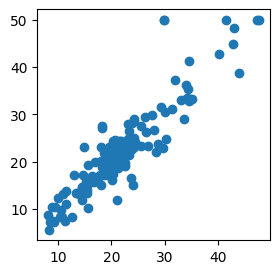

In [25]:
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot()
y_hat_bag = bag_boston.predict(X_test)
ax.scatter(y_hat_bag, y_test)
np.mean((y_test - y_hat_bag) ** 2)

In [26]:
bag_boston = RF(max_features=X_train.shape[1], n_estimators=500, random_state=0).fit(
    X_train, y_train
)
y_hat_bag = bag_boston.predict(X_test)
np.mean((y_test - y_hat_bag) ** 2)

np.float64(14.605662565263161)

In [27]:
RF_boston = RF(max_features=6, random_state=0).fit(X_train, y_train)
y_hat_RF = RF_boston.predict(X_test)
np.mean((y_test - y_hat_RF) ** 2)

np.float64(20.04276446710527)

In [28]:
feature_imp = pd.DataFrame(
    {"importance": RF_boston.feature_importances_}, index=feature_names
)
feature_imp.sort_values(by="importance", ascending=False)

,importance
lstat,0.356203
rm,0.332163
ptratio,0.067270
crim,0.055404
indus,0.053851
dis,0.041582
nox,0.035225
tax,0.025355
age,0.021506
rad,0.004784


## Boosting

In [29]:
boost_boston = GBR(n_estimators=5000, learning_rate=0.001, max_depth=3, random_state=0)
boost_boston.fit(X_train, y_train)

,loss,'squared_error'
,learning_rate,0.001
,n_estimators,5000
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


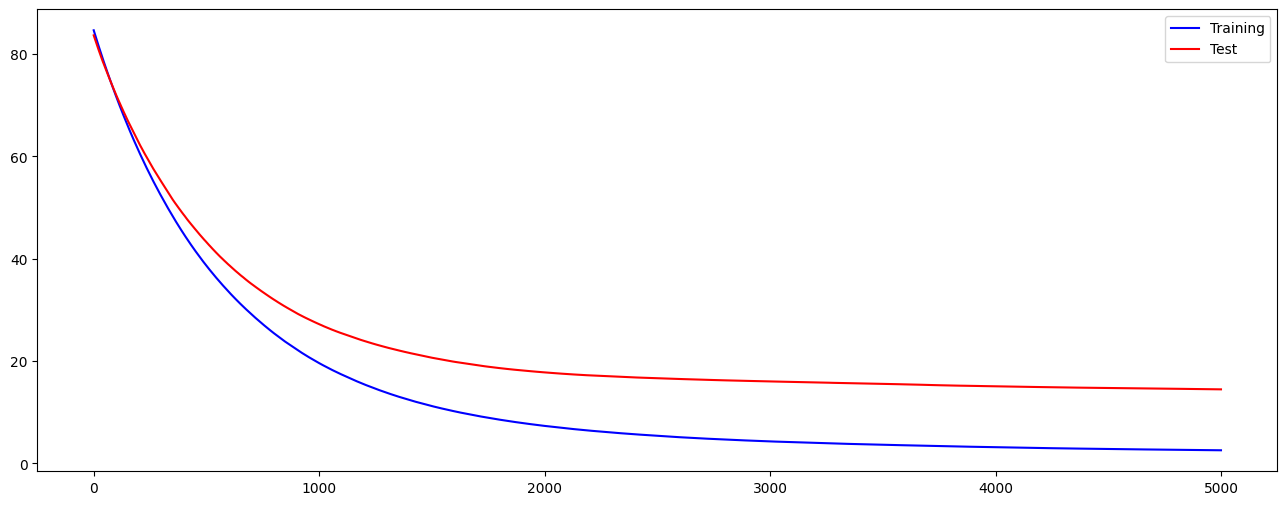

In [30]:
test_error = np.zeros_like(boost_boston.train_score_)
for idx, y_ in enumerate(boost_boston.staged_predict(X_test)):
    test_error[idx] = np.mean((y_test - y_) ** 2)

plot_idx = np.arange(boost_boston.train_score_.shape[0])
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot()
ax.plot(plot_idx, boost_boston.train_score_, "b", label="Training")
ax.plot(plot_idx, test_error, "r", label="Test")
ax.legend()

In [31]:
y_hat_boost = boost_boston.predict(X_test)
np.mean((y_test - y_hat_boost) ** 2)

np.float64(14.481405918831591)

In [32]:
boost_boston = GBR(n_estimators=5000, learning_rate=0.2, max_depth=3, random_state=0)
boost_boston.fit(X_train, y_train)
y_hat_boost = boost_boston.predict(X_test)
np.mean((y_test - y_hat_boost) ** 2)

np.float64(14.501514553719565)

## Bayesian Additive Regression Trees

In [33]:
bart_boston = BART(random_state=0, burnin=5, ndraw=15)
bart_boston.fit(X_train, y_train)

,num_trees,200
,num_particles,10
,max_stages,5000
,split_prob,<function BAR...x76e952f40700>
,min_depth,0
,std_scale,2
,split_prior,None
,ndraw,15
,burnin,5
,sigma_prior,"(5, ...)"
,num_quantile,50


In [34]:
yhat_test = bart_boston.predict(X_test.astype(np.float32))
np.mean((y_test - yhat_test) ** 2)

np.float64(22.145009458109225)

In [34]:
var_inclusion = pd.Series(bart_boston.variable_inclusion_.mean(0), index=D.columns)
var_inclusion

crim       25.466667
zn         30.600000
indus      24.933333
chas       21.133333
nox        27.333333
rm         28.800000
age        23.466667
dis        26.000000
rad        25.000000
tax        21.733333
ptratio    26.800000
lstat      31.866667
dtype: float64

# Exercises

## Conceptual

1. Draw an example (of your own invention) of a partition of two-dimensional feature space that could result from recursive binary splitting. Your example should contain at least six regions. Draw a decision tree corresponding to this partition. Be sure to label all aspects of your figures, including the regions R1, R2, ...., the cutpoints t1, t2,...., and so forth.
   Result should look like:

   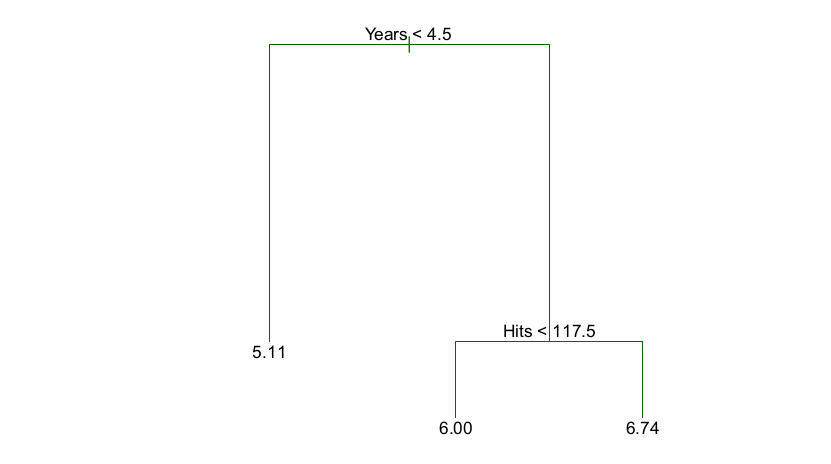 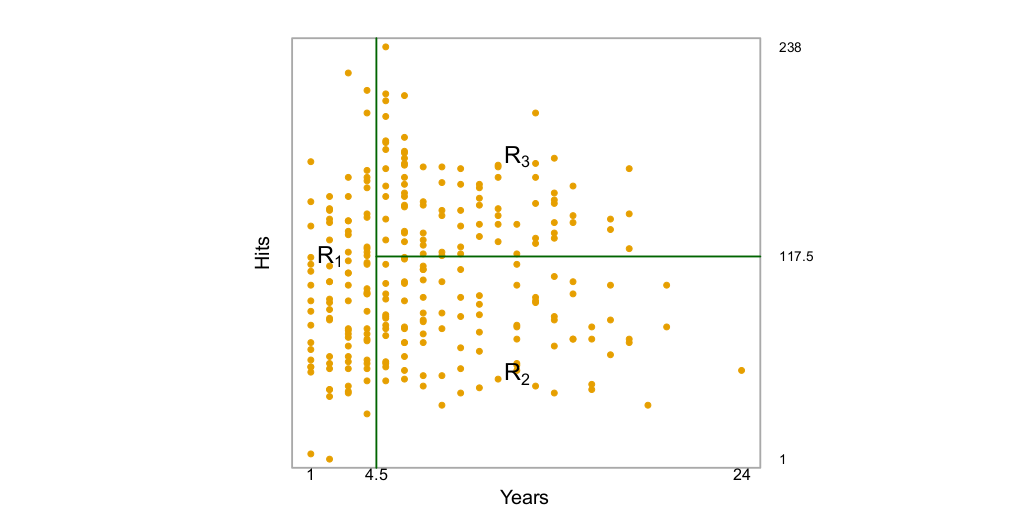

   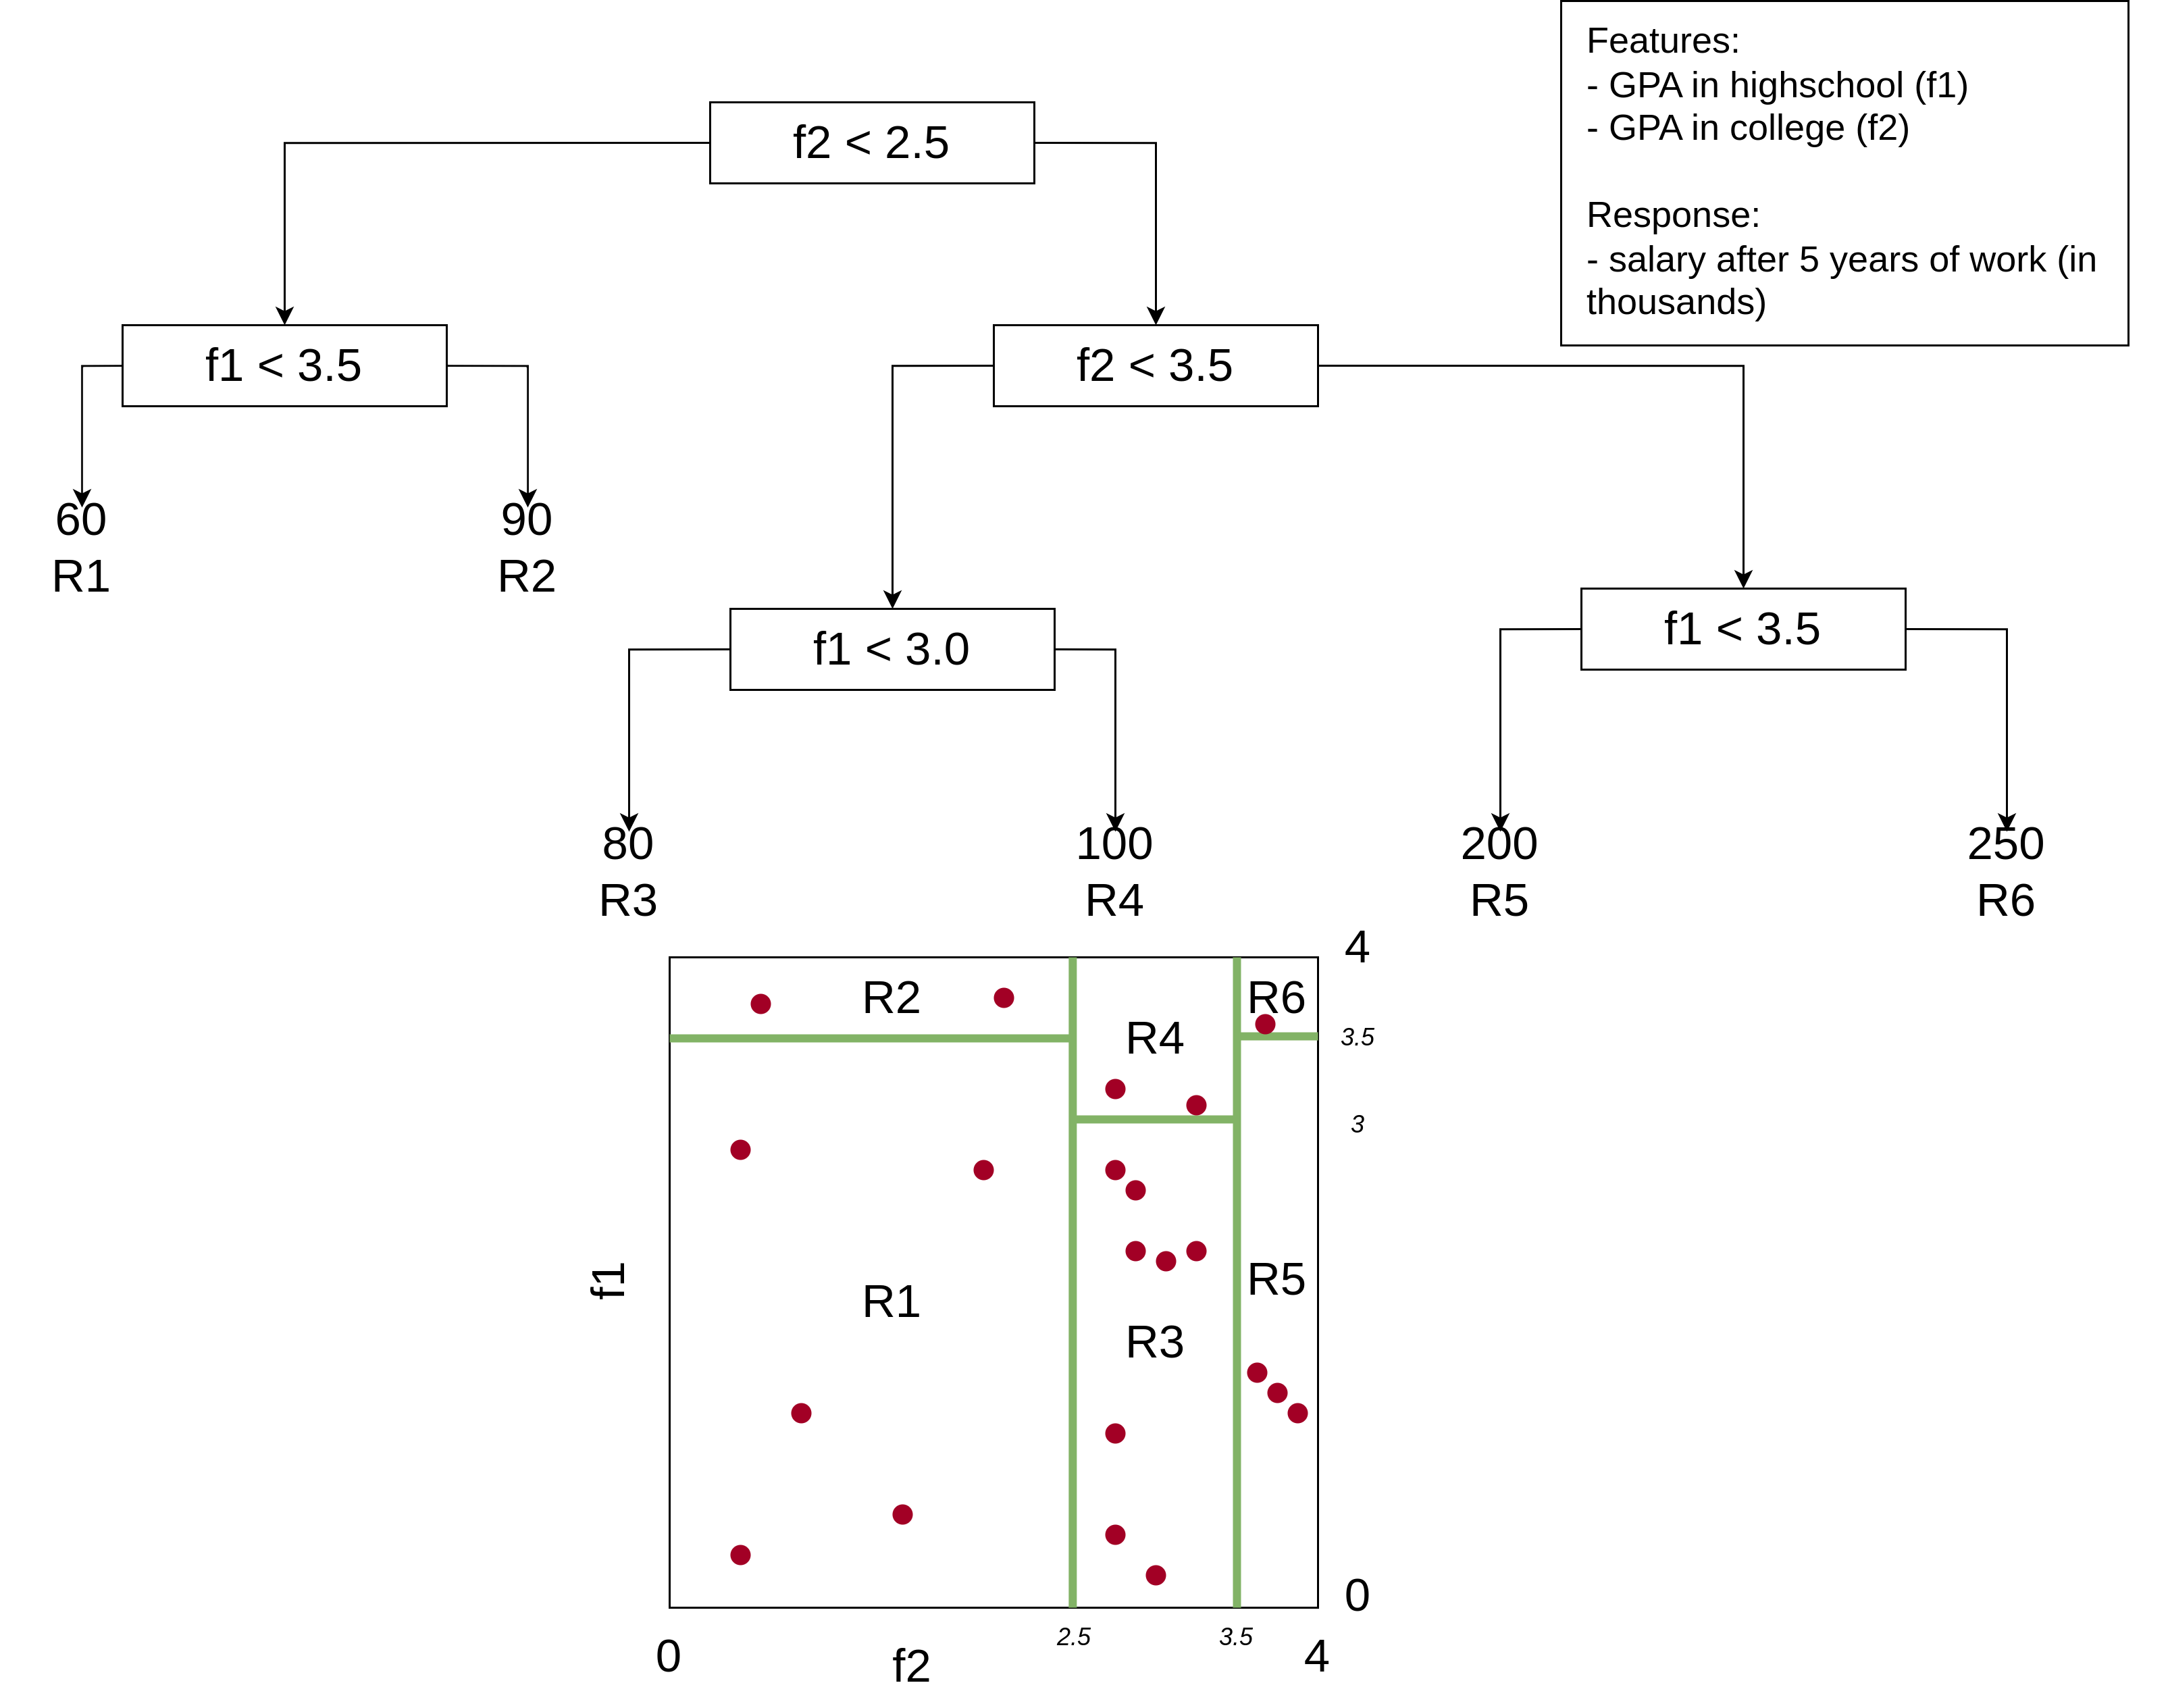

2. It is mentioned in Section 8.2.3 that boosting using depth-one trees (or stumps) leads to an additive model: that is, a model of the form

   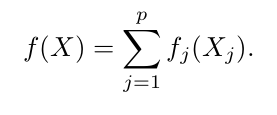

   Explain why this is the case. You can begin with 8.12 in Algorithm 8.2.

It is the case because fj(Xj) is equal with the weighted sum of iterations in which J was used as the splitting feature, thus confirming the form above.

3. Consider the Gini index, classification error, and entropy in a simple classification setting with two classes. Create a single plot that displays each of these quantities as a function of pm1. The x-axis should display pm1, ranging from 0 to 1, and the y-axis should display the value of the Gini index, classification error, and entropy.

In [35]:
pm1_hat = np.linspace(0, 1, 10000)
pm2_hat = 1 - pm1_hat
classification_error = 1 - np.where(pm1_hat > pm2_hat, pm1_hat, pm2_hat)
gini = np.add(pm1_hat * (1 - pm1_hat), pm2_hat * (1 - pm2_hat))
entropy = -(np.add((pm1_hat * np.log(pm1_hat)), (pm2_hat * np.log(pm2_hat))))

/tmp/ipykernel_91903/3573516185.py:5: RuntimeWarning: divide by zero encountered in log
  entropy = -(np.add((pm1_hat*np.log(pm1_hat)), (pm2_hat*np.log(pm2_hat))))
/tmp/ipykernel_91903/3573516185.py:5: RuntimeWarning: invalid value encountered in multiply
  entropy = -(np.add((pm1_hat*np.log(pm1_hat)), (pm2_hat*np.log(pm2_hat))))


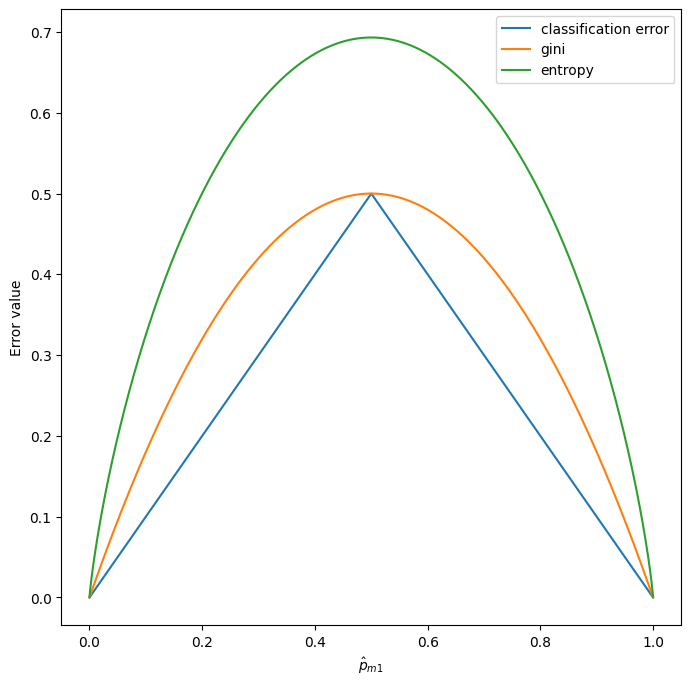

In [36]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()
ax.plot(pm1_hat, classification_error, label="classification error")
ax.plot(pm1_hat, gini, label="gini")
ax.plot(pm1_hat, entropy, label="entropy")
ax.set_xlabel(r"$\hat{p}_{m1}$")
ax.set_ylabel("Error value")
ax.legend()

4. This question relates to the plots in Figure 8.14.

   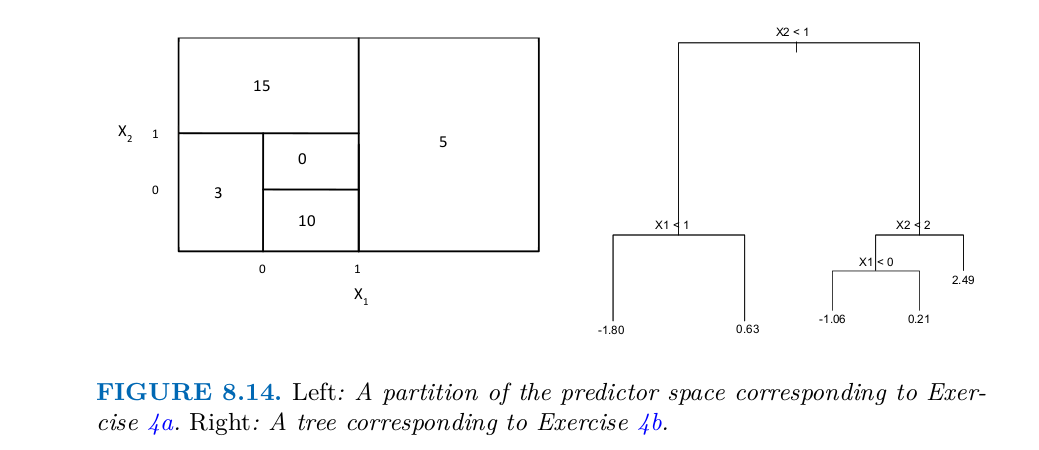

   (a) Sketch the tree corresponding to the partition of the predictor space illustrated in the left-hand panel of Figure 8.14. The numbers inside the boxes indicate the mean of Y within each region.

   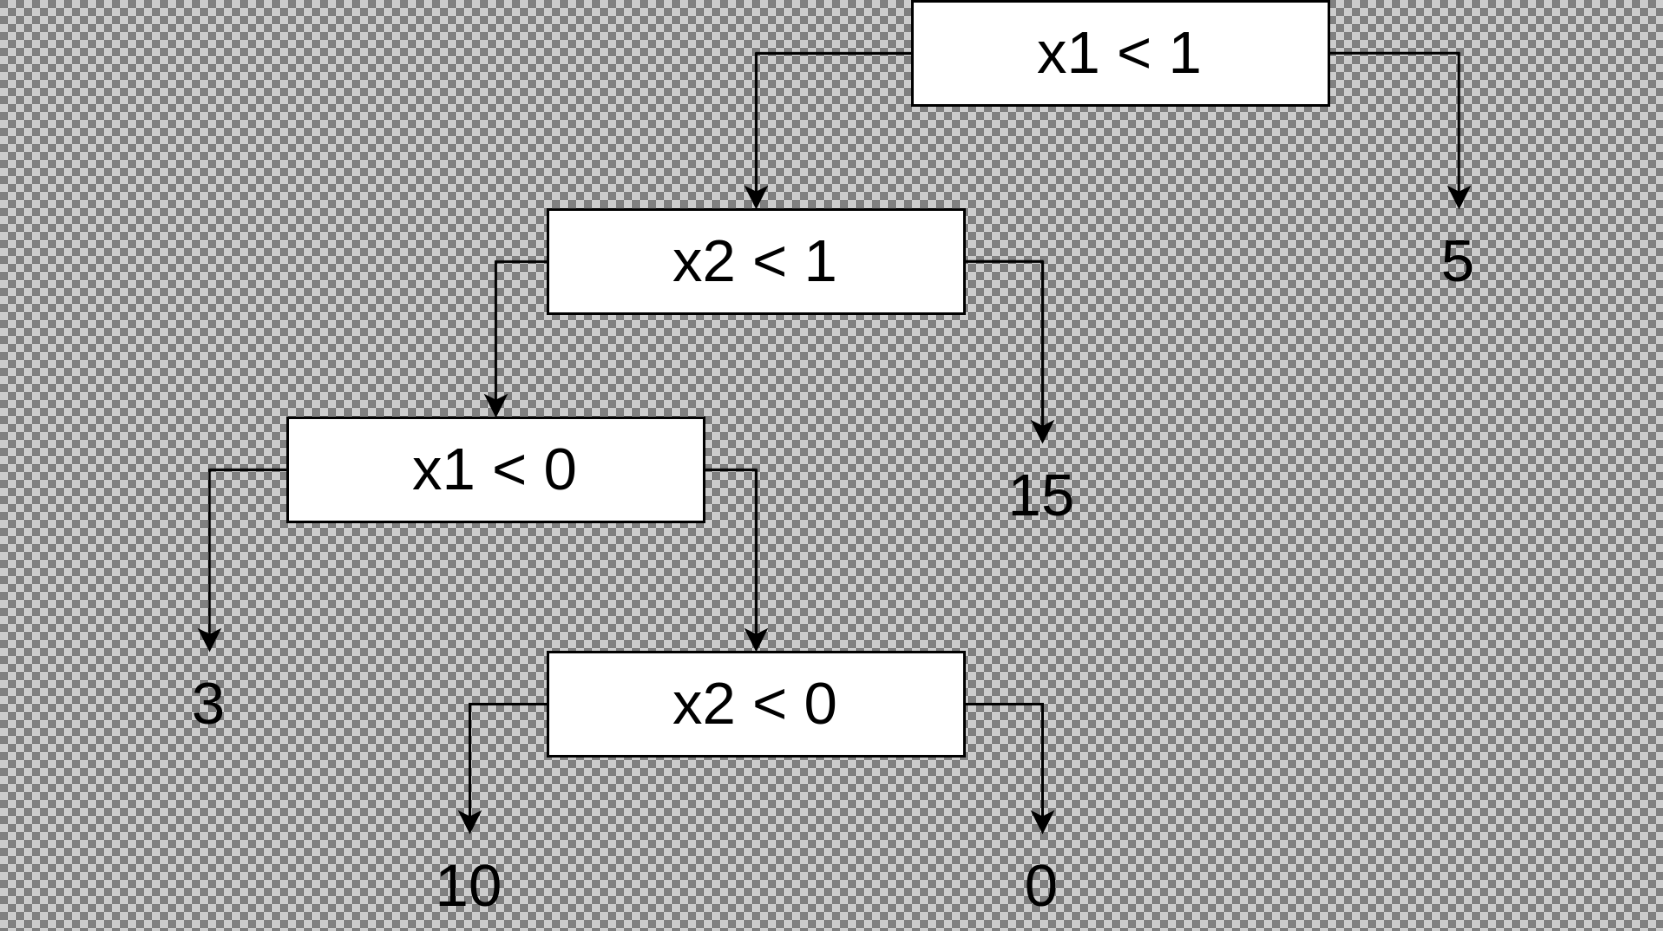

(b) Create a diagram similar to the left-hand panel of Figure 8.14, using the tree illustrated in the right hand panel of the same figure. YOu should divide up the predictor space into the correct regions, and indicate the mean for each region.


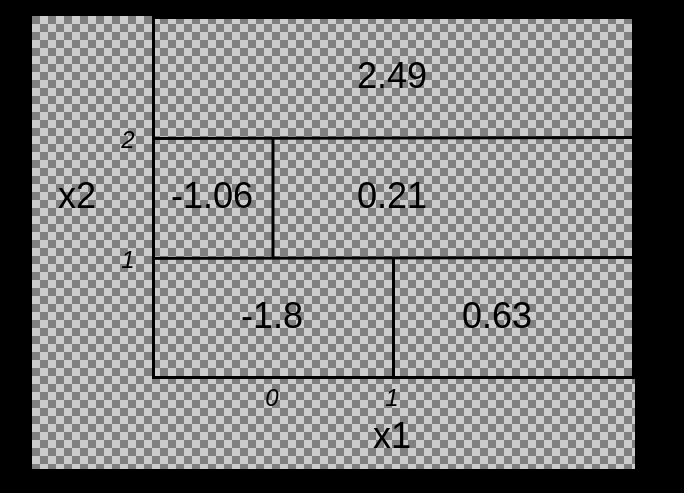

5. Suppose we produce ten bootstrapped samples from a data set containing red and green classes. We then apply a classification tree to each bootstrapped sample and, for a specific value of X, produce 10 estimates of P(Class is Red|X):

   0.1, 0.15, 0.2, 0.2, 0.55, 0.6, 0.6, 0.65, 0.7 and 0.75.

There are two common ways to combine these results together into a single class prediction. One is the majority vote approach discussed in this chapter. The second approach is to classify based on the average probability. In this example, what is the final classification under each of these two approaches?

In [37]:
from collections import Counter

probs = np.array([0.1, 0.15, 0.2, 0.2, 0.55, 0.6, 0.6, 0.65, 0.7, 0.75])
method_1 = Counter(np.where(probs > 0.5, True, False)).most_common()[0][0]
print("Method 1:", method_1)
method_2 = np.mean(probs) > 0.5
print("Method 2:", method_2)

Method 1: True
Method 2: False


6. Provide a detailed explanation of the algorithm that is used to fit a regression tree.

Binary splitting is an approach used to fit a regression tree. The tree starts from the most important feature which provides the lowest RSS value. The tree keeps growing until an arbitrary n value which indicates the minimum number of observations corresponding to that particular leaf. Each terminal node (leaf) has a value corresponding to it, which is the mean value of all the observations that fall into that region.

After that, apply "cost complexity pruning" to obtain a sequence of best subtrees, as a function of alpha. Alpha can be chosen using K-fold cross-validation.

# Applied

7. In section 8.3.3 we applied random forests to the Boston data using max_features=6, and using n_estimators=100 and n_estimators=500. Create a plot displaying the test error resulting from random forests on this data set for a more comprehensive range of values for max_features and n_estimators. You can model your plot after Figure 8.10. Describe the results obtained.

In [179]:
X_train, X_test, Y_train, Y_test = skm.train_test_split(
    Boston.drop(columns="medv"), Boston["medv"], test_size=0.5, random_state=0
)

In [180]:
import math

param_grid = {
    "max_features": np.arange(1, X_train.shape[1]),
    "n_estimators": np.arange(1, 101),
}
classifier = RF(n_estimators=10, max_features=6, random_state=0)

grid = skm.GridSearchCV(
    classifier, param_grid, scoring="neg_mean_squared_error", verbose=True
).fit(X_train, Y_train)

Fitting 5 folds for each of 1100 candidates, totalling 5500 fits


In [181]:
fits = pd.DataFrame(
    [
        {**candidate, "MSE": -MSE}
        for candidate, MSE in zip(
            grid.cv_results_["params"], grid.cv_results_["mean_test_score"]
        )
    ]
)
fits[fits["max_features"] == 1]

,max_features,n_estimators,MSE
0,1,1,53.678816
1,1,2,32.190381
2,1,3,36.084641
3,1,4,28.309611
4,1,5,27.669673
...,...,...,...
95,1,96,20.795688
96,1,97,20.717033
97,1,98,20.729195
98,1,99,20.746720


Text(0.5, 0, 'Number of Trees')

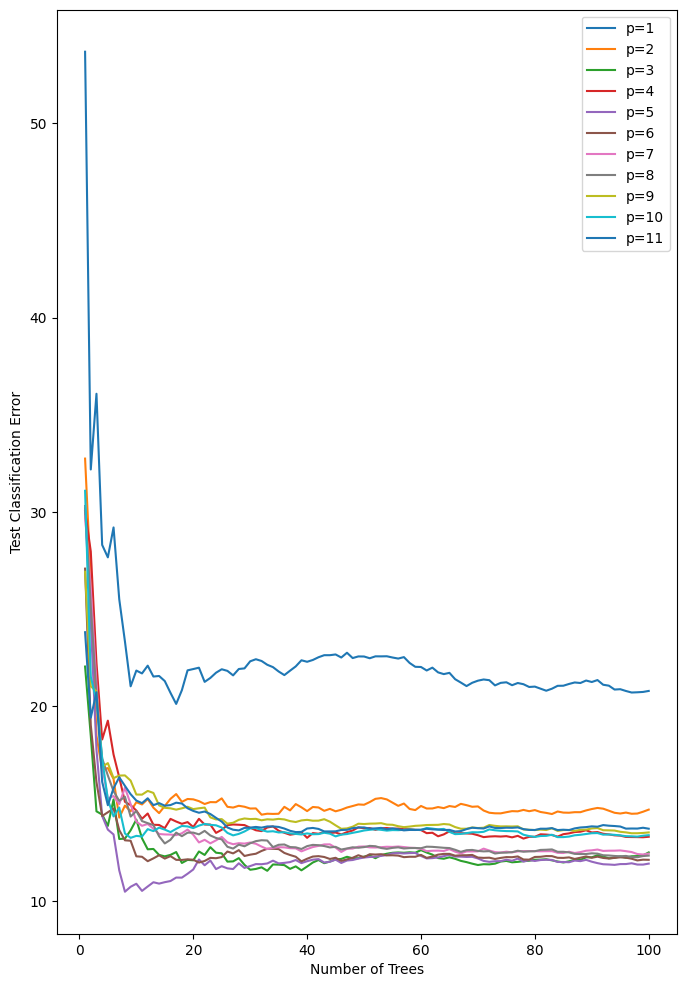

In [182]:
fig = plt.figure(figsize=(8, 12))
ax = fig.add_subplot()
for i in np.arange(1, X_train.shape[1]):
    df = fits[fits["max_features"] == i]
    ax.plot(np.arange(1, df.shape[0] + 1), df["MSE"], label=f"p={i}")
ax.legend()
ax.set_ylabel("Test Classification Error")
ax.set_xlabel("Number of Trees")

8. In the lab, a classification tree was applied to the Carseats data set after converting Sales into a qualitative response variable. Now we will seek to predict Sales using regression trees and related approaches, treating the  response as a quantitative variable.

   (a) Split the data set into a training set and a test set.

In [183]:
X = MS(Carseats.drop(columns="Sales").columns, intercept=False).fit_transform(Carseats)
feature_names = X.columns
y = Carseats["Sales"]
X_train, X_test, Y_train, Y_test = skm.train_test_split(
    X, y, random_state=0, test_size=0.5
)

(b) Fit a regression tree to the training set. Plot the tree, and interpret the results. What test MSE do you obtain?

In [184]:
classifier = DTR(random_state=0)
classifier.fit(X_train, Y_train)
np.mean((Y_test - classifier.predict(X_test)) ** 2)

6.198309500000001

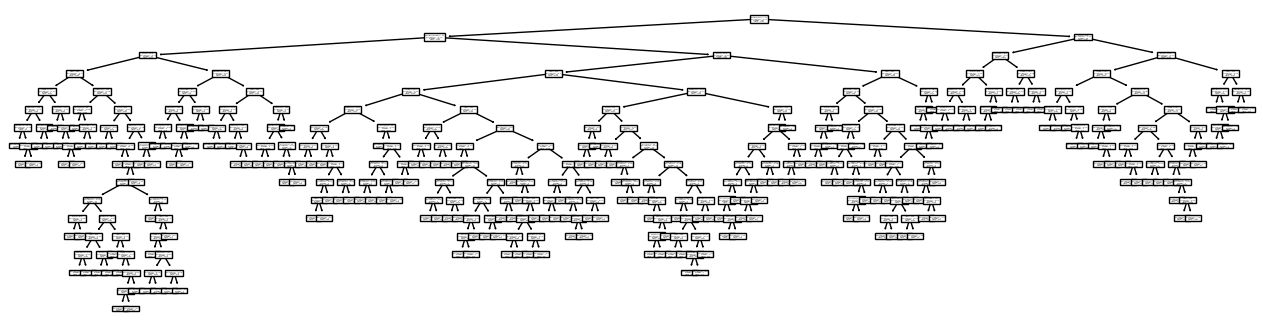

In [185]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot()
tree = plot_tree(classifier, feature_names=feature_names, ax=ax)

The MSE is 6.1983. The tree is quite complex, with a lot of terminal nodes.

(c) Use cross-validation in order to determine the optimal level of tree complexity

In [186]:
ccp_path = classifier.cost_complexity_pruning_path(X_train, Y_train)
grid = skm.GridSearchCV(
    classifier,
    {"ccp_alpha": ccp_path.ccp_alphas},
    refit=True,
    cv=kfold,
    scoring="neg_mean_squared_error",
)
grid.fit(X_train, Y_train)
np.mean((Y_test - grid.predict(X_test)) ** 2)

5.13160070941571

It does improve the test MSE.

(d) Use the bagging approach in order to analyze this data. What test MSE do you obtain? Use the feature_importance_ values to determine which variables are most important.

In [187]:
classifier = RF(n_estimators=1000, max_features=X_train.shape[1]).fit(X_train, Y_train)
print("MSE:", np.mean((Y_test - classifier.predict(X_test)) ** 2))
{k: v for k, v in zip(feature_names, classifier.feature_importances_)}

MSE: 2.6914105520519978


{'CompPrice': 0.08617154789959447,
 'Income': 0.06591195434513851,
 'Advertising': 0.05557153748777287,
 'Population': 0.05843003613732888,
 'Price': 0.33249249938091524,
 'ShelveLoc[Good]': 0.15875238239102502,
 'ShelveLoc[Medium]': 0.08216457757758114,
 'Age': 0.1156242032864405,
 'Education': 0.0318067413123111,
 'Urban[Yes]': 0.005608610718299456,
 'US[Yes]': 0.007465909463592828}

(e) Use random forests to analyze this data. What test MSE do you obtain? Use the feature importance method to determine which variables are most important. Describe the effect of m, the number of variables considered at each split, on the error rate obtained.

In [188]:
param_grid = {"max_features": range(1, X_train.shape[1])}
grid = skm.GridSearchCV(classifier, param_grid, scoring="neg_mean_squared_error").fit(
    X_train, Y_train
)

Text(0, 0.5, 'MSE')

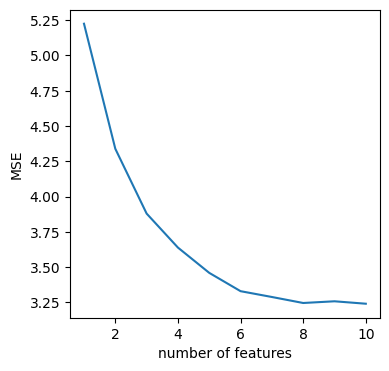

In [189]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot()
ax.plot(range(1, X_train.shape[1]), -grid.cv_results_["mean_test_score"])
ax.set_xlabel("number of features")
ax.set_ylabel("MSE")

In [190]:
classifier = RF(n_estimators=1000, max_features=grid.best_params_["max_features"]).fit(
    X_train, Y_train
)
{k: v for k, v in zip(feature_names, classifier.feature_importances_)}

{'CompPrice': 0.08862568624038338,
 'Income': 0.06704281495389061,
 'Advertising': 0.05661168050669829,
 'Population': 0.05781515796310343,
 'Price': 0.32739974478567213,
 'ShelveLoc[Good]': 0.1583451899740319,
 'ShelveLoc[Medium]': 0.08210978505982891,
 'Age': 0.11527734111106269,
 'Education': 0.03292912244005874,
 'Urban[Yes]': 0.0056031746233940905,
 'US[Yes]': 0.008240302341875786}

(f) Now analyze the data using BART, and report your results.

In [49]:
classifier = BART().fit(X_train, Y_train)
np.mean((Y_test - classifier.predict(np.asarray(X_test).astype(np.float32))) ** 2)

1.6514328552494069

In [50]:
var_inclusion = pd.Series(
    classifier.variable_inclusion_.mean(0), index=X_train.columns
).sort_values(ascending=False)
var_inclusion

Price                34.3
US[Yes]              29.0
ShelveLoc[Good]      28.9
CompPrice            28.0
ShelveLoc[Medium]    28.0
Age                  28.0
Urban[Yes]           26.8
Income               26.3
Advertising          25.5
Population           22.5
Education            22.0
dtype: float64

9. This problem involves the OJ data set which is part of the ISLP package.

    (a) Create a training set containing a random sample of 800 observations, and a test set containing the remaining observations.

I do not know why MS doesnt work on this data set, I will create the dummy variables manually.

In [51]:
OJ = load_data("OJ")
OJ["Store7"] = OJ["Store7"].astype("category")
model = MS(OJ.columns.drop("Purchase"), intercept=False).fit(OJ)
X = model.transform(OJ)
y = OJ["Purchase"]

In [52]:
X_train, X_test, Y_train, Y_test = skm.train_test_split(
    X, y, train_size=800, random_state=0
)

    (b) Fit a tree to the training data, with Purchase as the response and the other variables as predictors. What is the training error rate?

In [53]:
classifier = DTC(random_state=0)
classifier.fit(X_train, Y_train)

DecisionTreeClassifier(random_state=0)

In [54]:
print(
    "Training Accuracy:",
    accuracy_score(Y_train, classifier.predict(X_train)),
    "\n" + "Error:",
    1 - accuracy_score(Y_train, classifier.predict(X_train)),
)

Training Accuracy: 0.99125 
Error: 0.008750000000000036


    (c) Create a plot of the tree, and interpret the results. How many terminal nodes does the tree have?

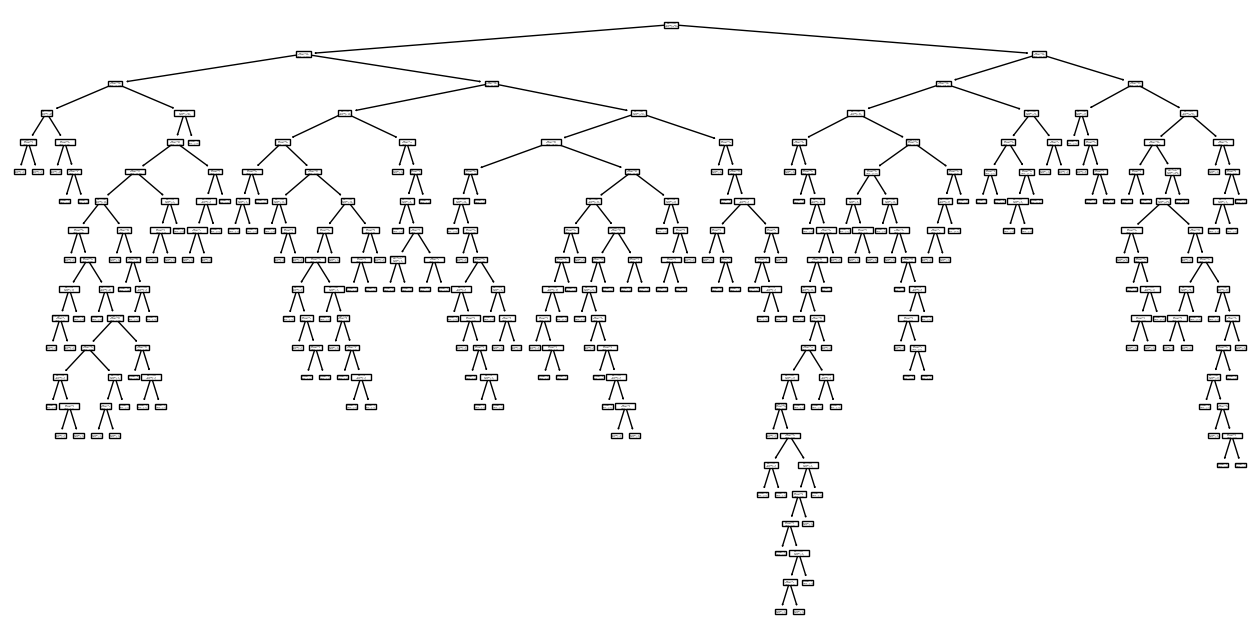

In [55]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot()
tree = plot_tree(classifier, feature_names=X_train.columns, ax=ax)

In [56]:
classifier.tree_.n_leaves

163

(d) Use the export_tree() function to produce a text summary of the fitter tree. Pick one of the terminal nodes, and interpret the information displayed.

In [57]:
print(
    export_text(
        classifier, feature_names=list(X_train.columns), show_weights=True, max_depth=2
    )
)

|--- LoyalCH <= 0.51
|   |--- LoyalCH <= 0.28
|   |   |--- LoyalCH <= 0.06
|   |   |   |--- truncated branch of depth 4
|   |   |--- LoyalCH >  0.06
|   |   |   |--- truncated branch of depth 12
|   |--- LoyalCH >  0.28
|   |   |--- PriceDiff <= 0.05
|   |   |   |--- truncated branch of depth 11
|   |   |--- PriceDiff >  0.05
|   |   |   |--- truncated branch of depth 12
|--- LoyalCH >  0.51
|   |--- LoyalCH <= 0.71
|   |   |--- PriceDiff <= 0.27
|   |   |   |--- truncated branch of depth 18
|   |   |--- PriceDiff >  0.27
|   |   |   |--- truncated branch of depth 5
|   |--- LoyalCH >  0.71
|   |   |--- PriceDiff <= -0.39
|   |   |   |--- truncated branch of depth 4
|   |   |--- PriceDiff >  -0.39
|   |   |   |--- truncated branch of depth 13



In [58]:
print(
    "\n".join(
        export_text(
            classifier,
            feature_names=list(X_train.columns),
            show_weights=True,
            max_depth=5,
        ).split("\n")[:6]
    )
)

|--- LoyalCH <= 0.51
|   |--- LoyalCH <= 0.28
|   |   |--- LoyalCH <= 0.06
|   |   |   |--- StoreID <= 1.50
|   |   |   |   |--- ListPriceDiff <= 0.15
|   |   |   |   |   |--- weights: [1.00, 0.00] class: CH


For a customer brand loyalty for Citrus Hill lower or equal to 0.06, a StoreID lower or equal to 1.5 and a list price difference between Minute Maid and Citrus Hill lower or equal to 0.15, the predicted class is Citrus Hill

(e) Predict the response on the test data, and produce a confusion matrix comparing the test labels to the predicted test labels. What is the test error rate?

In [59]:
confusion_table(classifier.predict(X_test), Y_test)

Truth,CH,MM
Predicted,,
CH,115,35
MM,38,82


In [60]:
print(
    "Test Accuracy:",
    accuracy_score(Y_test, classifier.predict(X_test)),
    "\n" + "Error:",
    1 - accuracy_score(Y_test, classifier.predict(X_test)),
)

Test Accuracy: 0.7296296296296296 
Error: 0.27037037037037037


(f) Use cross-validation on the training set in order to determine the optimal tree size.

In [61]:
param_grid = {"max_depth": range(1, classifier.tree_.max_depth)}
grid = skm.GridSearchCV(classifier, param_grid, cv=kfold, scoring="accuracy").fit(
    X_train, Y_train
)

    (g) Produce a plot with tree size on the x-axis and cross-validated classification error rate on the y-axis.

Text(0, 0.5, 'CV error')

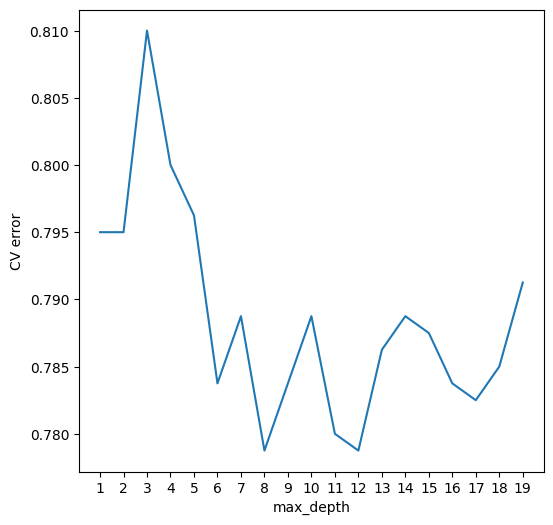

In [62]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot()
ax.plot(range(1, classifier.tree_.max_depth), grid.cv_results_["mean_test_score"])
ticks = ax.set_xticks(range(1, classifier.tree_.max_depth))
ax.set_xlabel("max_depth")
ax.set_ylabel("CV error")

(h) Which tree size corresponds to the lowest cross-validated classification error rate?

In [63]:
grid.best_params_

{'max_depth': 3}

(i) Produce a pruned tree corresponding to the optimal tree size obtained using cross-validation. If cross-validation does not lead to selection of a pruned tree, then create a pruned tree with five terminal nodes.

In [64]:
classifier = DTC(max_depth=3, random_state=0)
ccp_path = classifier.cost_complexity_pruning_path(X_train, Y_train)
grid = skm.GridSearchCV(
    classifier,
    {"ccp_alpha": ccp_path.ccp_alphas},
    refit=True,
    cv=kfold,
    scoring="accuracy",
)
grid.fit(X_train, Y_train)
grid.best_score_, grid.best_params_

(0.8100000000000002, {'ccp_alpha': 0.0})

In [65]:
pruned_classifier = DTC(max_depth=3, random_state=0, max_leaf_nodes=5).fit(
    X_train, Y_train
)

(j) Compare the training error rates between the pruned and unpruned trees. Which is higher?

In [66]:
print(
    "Unpruned training error:",
    1 - accuracy_score(Y_train, grid.predict(X_train)),
    "\nPruned training error:",
    1 - accuracy_score(Y_train, pruned_classifier.predict(X_train)),
)

Unpruned training error: 0.1775 
Pruned training error: 0.1975


(k) Compare the test error rates between the pruned and unpruned trees. Which is higher?

In [67]:
print(
    "Unpruned test error:",
    1 - accuracy_score(Y_test, grid.predict(X_test)),
    "\nPruned test error:",
    1 - accuracy_score(Y_test, pruned_classifier.predict(X_test)),
)

Unpruned test error: 0.18888888888888888 
Pruned test error: 0.2148148148148148


10. We now use boosting to predict Salary in the Hitters data set.

In [192]:
Hitters = load_data("Hitters")

    (a) Remove the observations for whom the salary information is unknown, and then log-transform the salaries.

In [193]:
Hitters = Hitters.dropna()
Hitters["Salary"] = np.log(Hitters["Salary"])
X = Hitters.drop(columns="Salary")
X = MS(X.columns, intercept=False).fit_transform(X)
y = Hitters["Salary"]

    (b) Create a training set consisting of the first 200 observations, and a test set consisting of the remaining observations.

In [194]:
X_train, X_test, Y_train, Y_test = skm.train_test_split(
    X, y, train_size=200, random_state=0
)

    (c) Perform boosting on the training set with 1000 trees for a range of values of the shrinkage parameter alpha. Produce a plot with different shrinkage values on the x-axis and the corresponding training set MSE on the y-axis.

    (d) Produce a plot with different shrinkage values on the x-axis and the corresponding test set MSE on the y-axis.

With a learning rate of 0.1 we achieve a training error of 9.236615031809748e-09 and a test error of 0.13252951824842474


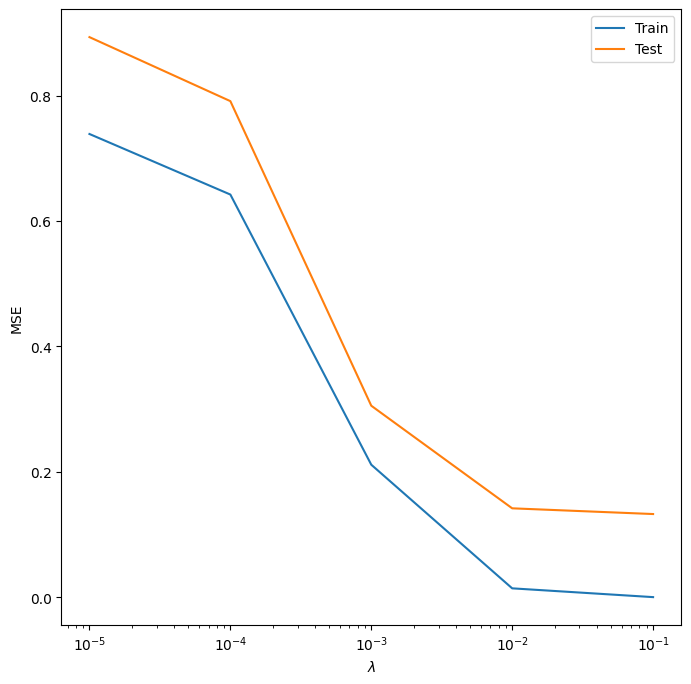

In [195]:
alphas = np.logspace(1, 5, base=0.1, num=5)
train_mse = np.zeros_like(alphas)
test_mse = np.zeros_like(alphas)
for i, alpha in enumerate(alphas):
    classifier = GBR(n_estimators=1000, random_state=0, learning_rate=alpha).fit(
        X_train, Y_train
    )
    train_mse[i] = np.mean((Y_train - classifier.predict(X_train)) ** 2)
    test_mse[i] = np.mean((Y_test - classifier.predict(X_test)) ** 2)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()
ax.plot(alphas, train_mse, label="Train")
ax.plot(alphas, test_mse, label="Test")
ax.set_xscale("log")
ax.set_xlabel(r"$ \lambda $")
ax.set_ylabel("MSE")
ax.legend()
print(
    f"With a learning rate of 0.1 we achieve a training error of {train_mse[0]} and a test error of {test_mse[0]}"
)

(e) Compare the test MSE of boosting to the test MSE that results from applying two of the regression approaches seen in Chapters 3 and 6.

#### Multiple Linear Regression

In [196]:
ols = sm.OLS(Y_train, sm.add_constant(X_train)).fit()
ols_preds = ols.predict(sm.add_constant(X_test))
np.mean((Y_test - ols_preds) ** 2)

0.4554944998613406

Much higher than that of the boosting approach.
Lets try with feature selection though.

In [197]:
from sklearn.feature_selection import SequentialFeatureSelector
import sklearn.linear_model as skl

lr = skl.LinearRegression()
forward_selection = SequentialFeatureSelector(
    lr, cv=kfold, n_features_to_select="auto"
).fit(X, y)
X_train_selected = X_train.loc[:, forward_selection.support_]
X_test_selected = X_test.loc[:, forward_selection.support_]
ols = sm.OLS(Y_train, sm.add_constant(X_train_selected)).fit()
ols_preds = ols.predict(sm.add_constant(X_test_selected))
np.mean((Y_test - ols_preds) ** 2)

0.3966438466220438

Boosting MSE is still lower even with feature selection.

#### Principal component analysis

In [198]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


pca = PCA()
scaler = StandardScaler()
linreg = skl.LinearRegression()
pipe = Pipeline([("scaler", scaler), ("pca", pca), ("linreg", linreg)])
param_grid = {"pca__n_components": range(1, X_train.shape[1])}
grid = skm.GridSearchCV(
    pipe, param_grid, scoring="neg_mean_squared_error", cv=kfold, verbose=1
)
grid.fit(X_train, Y_train)
Y_pred = grid.predict(X_test)
mean_squared_error(Y_test, Y_pred)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


0.4323155385482218

#### Partial least squares

In [199]:
pls = PLSRegression()
scaler = StandardScaler()
linreg = skl.LinearRegression()
pipe = Pipeline([("scaler", scaler), ("pls", pls)])
param_grid = {"pls__n_components": range(1, X_train.shape[1])}
grid = skm.GridSearchCV(
    pipe, param_grid, scoring="neg_mean_squared_error", cv=kfold, verbose=1
)
grid.fit(X_train, Y_train)
Y_pred = grid.predict(X_test)
mean_squared_error(Y_test, Y_pred)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


0.43795012406172196

#### Ridge regression

In [200]:
import warnings

warnings.filterwarnings("ignore")


lambdas = 10 ** np.linspace(8, -2, Y_train.shape[0]) / Y_train.std()
scaler = StandardScaler(with_mean=True, with_std=True)
ridge = skl.ElasticNetCV(l1_ratio=0, alphas=lambdas, random_state=0, cv=kfold)
pipe = Pipeline([("scaler", scaler), ("ridge", ridge)])
pipe.fit(X_train, Y_train)
Y_pred = pipe.predict(X_test)
mean_squared_error(Y_test, Y_pred)

0.42357495719783506

In [201]:
lasso = skl.ElasticNetCV(n_alphas=100, l1_ratio=1, cv=kfold)
pipe = Pipeline(steps=[("scaler", scaler), ("lasso", lasso)])
pipe.fit(X_train, Y_train)
Y_pred = pipe.predict(X_test)
mean_squared_error(Y_test, Y_pred)

0.4125716104659505

Boosting performed a lot better than all of these methods.

(f) Which variables appear to be the most important predictors in the boosted model?

<BarContainer object of 19 artists>

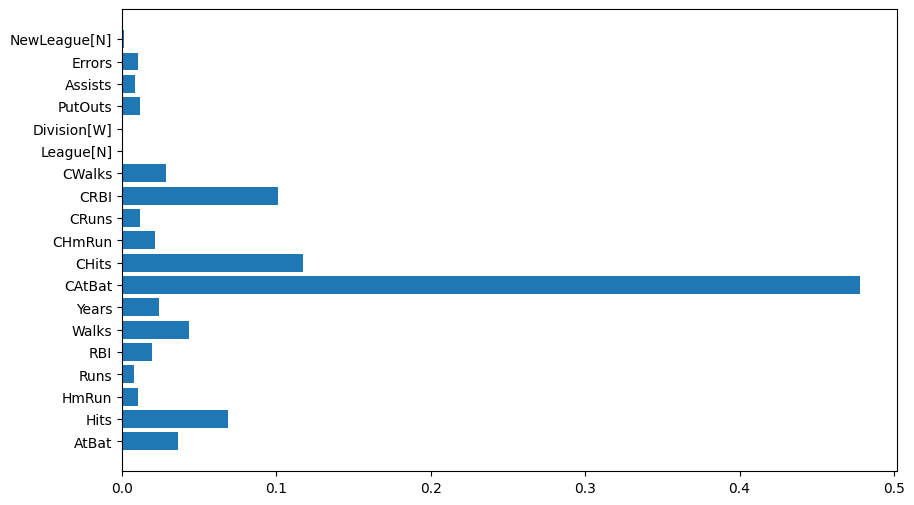

In [202]:
classifier = GBR(learning_rate=0.1, n_estimators=1000, random_state=0)
classifier.fit(X_train, Y_train)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot()
ax.barh(X_train.columns, classifier.feature_importances_)

(g) Now apply bagging to the training set. What is the test set MSE for this approach?

In [203]:
classifier = RF(n_estimators=1000, max_features=X_train.shape[1], random_state=0)
classifier.fit(X_train, Y_train)
mean_squared_error(Y_test, classifier.predict(X_test))

0.14092805674402661

Very close to the boosting approach.

11. This question uses the Caravan data set.

    (a) Create a training est consisting of the first 1000 observations, and a test set consisting of the remaining observations.

In [237]:
Caravan = load_data("Caravan")
X = Caravan.drop(columns="Purchase")
y = Caravan["Purchase"].astype("category")

X_train, X_test, Y_train, Y_test = skm.train_test_split(
    X, y, train_size=1000, random_state=0
)

    (b) Fit a boosting model to the training set with Purchase as the response and the other variables as the predictors. Use 1000 trees, and a shrinkage value of 0.01. Which predictors appear to be the most important?

In [238]:
classifier = GBC(learning_rate=0.01, n_estimators=1000, random_state=0)
classifier.fit(X_train, Y_train)

GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000,
                           random_state=0)

<BarContainer object of 85 artists>

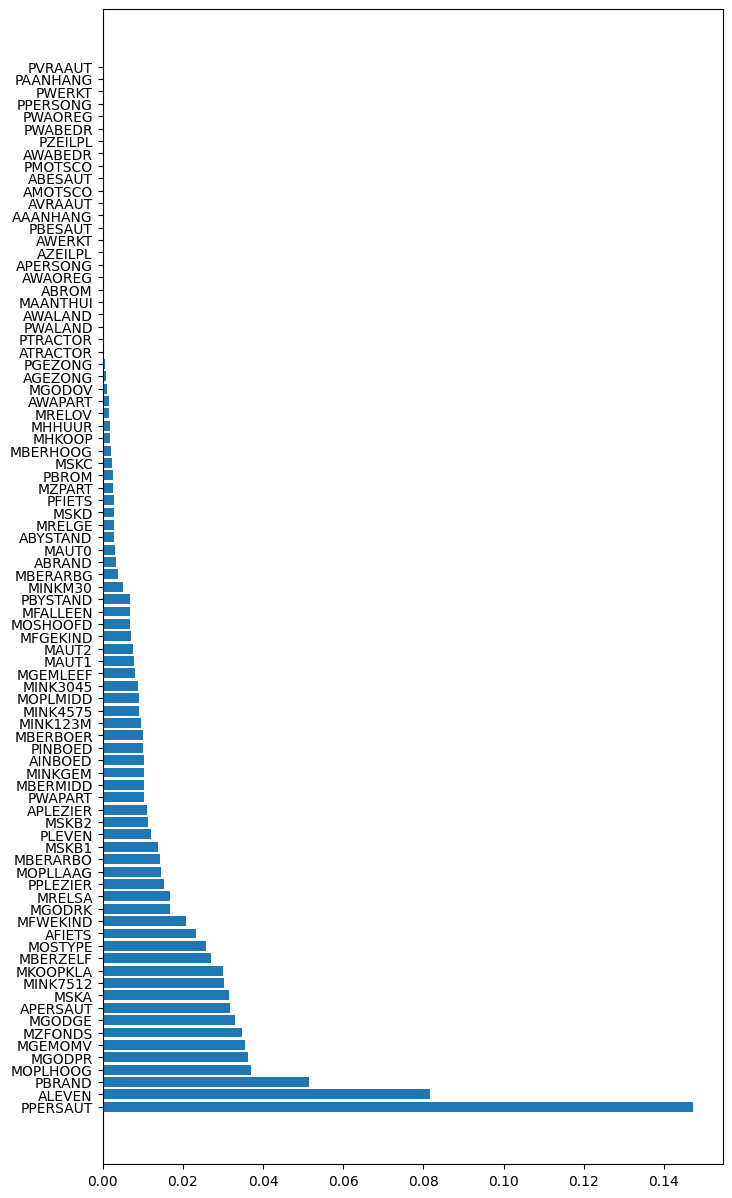

In [239]:
feature_importance = pd.DataFrame.from_dict(
    {k: v for k, v in zip(X_train.columns, classifier.feature_importances_)},
    orient="index",
    columns=["importance"],
).sort_values(by="importance", ascending=False)

fig = plt.figure(figsize=(8, 15))
ax = fig.add_subplot()
ax.barh(feature_importance.index, feature_importance.importance)

In [240]:
feature_importance[:5]

,importance
PPERSAUT,0.147265
ALEVEN,0.081763
PBRAND,0.051375
MOPLHOOG,0.036919
MGODPR,0.036379


(c) Use the boosting model to predict the response on the test data. Predict that a person will make a purchase if the estimated probability of purchase is greater than 20%. Form a confusion matrix. What fraction of the people predicted to make a purchase do in fact make one? How does this compare with the results obtained from applying KNN or logistic regression to this data set?

In [285]:
prob_of_purchase = classifier.predict_proba(X_test)[:, 1]
pred_purchase = np.where(prob_of_purchase > 0.2, "Yes", "No")
display(confusion_table(pred_purchase, Y_test))
print(
    f"Out of {206 + 44} predicted to make a purchase, only 44 ({44 / (206 + 44) * 100}%) do purchase"
)

Truth,No,Yes
Predicted,,
No,4326,246
Yes,206,44


Out of 250 predicted to make a purchase, only 44 (17.599999999999998%) do purchase


#### Compared to logistic regression

In [287]:
logreg = sm.GLM(
    Y_train.cat.codes, sm.add_constant(X_train), family=sm.families.Binomial()
).fit()
pred_purchase = np.where(logreg.predict(sm.add_constant(X_test)) > 0.2, "Yes", "No")
display(confusion_table(pred_purchase, Y_test))
print(
    f"Out of {342 + 63} predicted to make a purchase, only 63 ({63 / (342 + 63) * 100}%) do purchase"
)

Truth,No,Yes
Predicted,,
No,4190,227
Yes,342,63


Out of 405 predicted to make a purchase, only 63 (15.555555555555555%) do purchase


#### Compared to KNN

In [297]:
from sklearn.neighbors import KNeighborsClassifier as KNN

knn = KNN().fit(X_train, Y_train)

prob_of_purchase = knn.predict_proba(X_test)[:, 1]
pred_purchase = np.where(prob_of_purchase > 0.2, "Yes", "No")
display(confusion_table(pred_purchase, Y_test))
print(
    f"Out of {220 + 44} predicted to make a purchase, only 44 ({44 / (220 + 44) * 100}%) do purchase"
)

Truth,No,Yes
Predicted,,
No,4312,246
Yes,220,44


Out of 264 predicted to make a purchase, only 44 (16.666666666666664%) do purchase


Boosting performed better than KNN and logistic regression.

12. Apply boosting, bagging, random forests and BART to a data set of your choice. Be sure to fit the models on a training set and to evaluate their performance on a test set. How accurate are the results compared to simple methods like linear or logistic regression? Which of these approaches yields the best performance?

In [344]:
Smarket = load_data("Smarket")
X = Smarket.loc[:, "Lag1":"Lag5"]
y = Smarket["Direction"].astype("category")

X_train, X_test, Y_train, Y_test = skm.train_test_split(
    X, y, random_state=0, test_size=0.2
)

#### Bagging

In [327]:
bagging = RFC(n_estimators=1000, max_features=X_train.shape[1], random_state=0)
bagging.fit(X_train, Y_train)
accuracy_score(Y_test, bagging.predict(X_test))

0.5

#### Random Forests

In [333]:
param_grid = {"max_features": range(1, X_train.shape[1]), "max_depth": range(1, 10)}

rf = RFC(n_estimators=100, random_state=0)
rf_grid = skm.GridSearchCV(rf, param_grid, cv=kfold, scoring="accuracy")
rf_grid.fit(X_train, Y_train)
accuracy_score(Y_test, rf_grid.predict(X_test))

0.52

A little bit better than a coinflip!

#### Boosting

In [338]:
param_grid = {"learning_rate": [0.1, 0.01, 0.001], "max_depth": range(1, 10)}
boosting = GBC(n_estimators=300, random_state=0)
boosting_grid = skm.GridSearchCV(boosting, param_grid, cv=kfold, scoring="accuracy")
boosting_grid.fit(X_train, Y_train)
accuracy_score(Y_test, boosting_grid.predict(X_test))

0.532

We are making advancements!

#### BART

In [359]:
bart = BART().fit(np.asarray(X_train), np.asarray(Y_train.cat.codes.astype("int")))

In [369]:
accuracy_score(Y_test, np.where(bart.predict(np.asarray(X_test)) > 0.5, "Up", "Down"))

0.532

#### Logistic Regression

In [371]:
logreg = sm.GLM(
    Y_train.cat.codes, sm.add_constant(X_train), family=sm.families.Binomial()
).fit()
accuracy_score(
    Y_test, np.where(logreg.predict(sm.add_constant(X_test)) > 0.5, "Up", "Down")
)

0.512

Boosting and BART seem to have the best performance.